### 1. Problem Definition
* This is a binary classification problem either a customer is churn or not

* We will use several features to predict(classify) customers will churn or not

### 2. Data
**Data source:** [Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

There are 11 features and 1 target column.

### 3. Evaluation
What define success(Proof Of Concept): we decided to move forward the project if we meet 95% accuracy. However, as the experimentational characteristic of machine learning this evaluation metric can be changed along the way.

### 4. Features
The 11 independent columns are the following.
1. customer_id, unused variable.
2. credit_score, used as input.
3. country, used as input.
4. gender, used as input.
5. age, used as input.
6. tenure, used as input.
7. balance, used as input.
8. products_number, used as input.
9. credit_card, used as input.
10. active_member, used as input.
11. estimated_salary, used as input.

The target column is the following
- churn, used as the target. 1 if the client has left the bank during some period or 0 if he/she has not.

### Importing tools

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

### Load Data

In [3]:
df = pd.read_csv("Bank Customer Churn Prediction.csv")
df.shape

(10000, 12)

In [4]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### EDA (Exploratory Data Analysis)

In [5]:
# let's see how many people in each categories (1: churn, 0: not churn)
df.churn.value_counts()

0    7963
1    2037
Name: churn, dtype: int64

We can see that the target values are not balanced between the two.

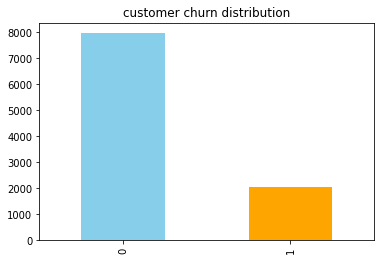

In [16]:
# plot the target 
df.churn.value_counts().plot.bar(color=["skyblue", "orange"])
plt.title("customer churn distribution");

In [18]:
# let's see if we have missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


There is no missing value in every columns.

In [19]:
# let's make a baseline assumption: if a customer is an active_member, they might not be churn
df.active_member.value_counts()

1    5151
0    4849
Name: active_member, dtype: int64

In [20]:
pd.crosstab(df.churn, df.active_member)

active_member,0,1
churn,,
0,3547,4416
1,1302,735


From the table, we can assume that out of about 5000 active member, 700 of them became churn (14%), where as out of about 5000 inactive members, 1300 became churn (26%).

<Axes: xlabel='churn'>

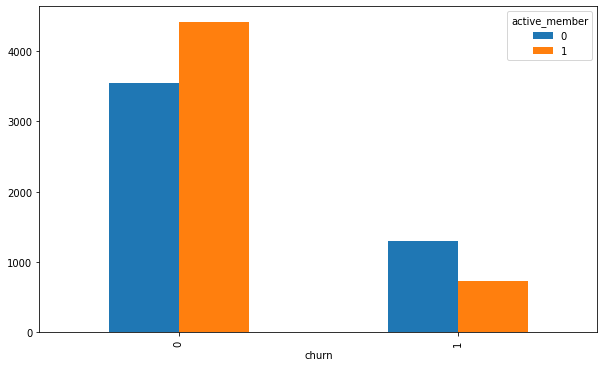

In [24]:
# let's make a bar plot
pd.crosstab(df.churn, df.active_member).plot.bar(figsize=(10,6))

This plot shows that among churn customers, there are inactive members as twice as active members, showing the importance of customer retention.